In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x57dc6000 @  0x7f28d220f2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

In [0]:
import seaborn as sns

In [0]:
cuda = torch.cuda.is_available()

In [0]:
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

Using PyTorch version: 0.4.1 CUDA: True


In [0]:
torch.manual_seed(42)
if(cuda):
  torch.cuda.manual_seed(42)

In [0]:
batch_size = 32
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(datasets.MNIST('data_', train=True, download=True, transform=transforms.
                                           Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])),
                           batch_size=batch_size, shuffle=True, **kwargs )

test_loader = torch.utils.data.DataLoader(datasets.MNIST('data_', train=False, download=True, transform=transforms.
                                                         Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),
                                          batch_size=batch_size, shuffle=True, **kwargs)


Processing...
Done!
Processing...
Done!


**DataLoader provides single- or multi-process iterators over the dataset.**

In [0]:
train_loader, len(train_loader.dataset)

(<torch.utils.data.dataloader.DataLoader at 0x7fbd276f9be0>, 60000)

In [0]:
count = 0
for (x_train, y_train) in train_loader:
  count += 1
print(count, x_train.size(), y_train.size())

1875 torch.Size([32, 1, 28, 28]) torch.Size([32])


Above we are checking the size of our data. 1875 tells us there are these many batches of training dataset is present. Then [32,1,28,28] it tells us that the batch size is 32 and each image is of dimention 1,28,28. 1 indicates that it is a greyscale image. If 3 is written instead of 1 then it shows that we have an RGB image, 3 means three different channels. And our training label size is 32 as we have 32 images in a batch. 

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28*28, 50)
    self.fc1_drop = nn.Dropout(0.2)
    self.fc2 = nn.Linear(50, 50)
    self.fc2_drop = nn.Dropout(0.2)
    self.fc3 = nn.Linear(50, 10)
   
  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.fc1_drop(x)
    x = F.relu(self.fc2(x))
    x = self.fc2_drop(x)
    return F.log_softmax(self.fc3(x))

Neural networks can be constructed using the torch.nn package. An "nn.Module" contains layers, and a method forward(input) that returns the output. <br>
Above, we created the structure of our network in the __init__**()** . <br>
*   **"nn.Linear(28*28, 50)" :** It says there are 28*28 neurons in our input layer. 28*28 because our image is in 1,28,28. So we need to flatten it to pass it to the network. And 50 neurons in the first hidden layer. We have then assign this to a variable fc1.
*   **"nn.Dropout(0.2)" :** Here we are adding dropout to our first layer. Which means that some of the neurons will randomly be switched off. And hence there weights will not be considered. Value 0.2 means 20% of the neurons will be stopped.
*   **"nn.Linear(50,50)" :** Here we have 50 neurons in first hidden layer and 50 neurons in second hidden layer.
*   **"nn.Dropout(0.2)" :** Again we have used Dropout 20%.
*   **"nn.Linear(50,10)" :** Here 50 neuron of second hidden layer and 10 neurons in the output layer. We have put 10 neurons in the output layer because in out MNIST dataset we have numbers from 0 to 9. So we have 10 different classes.
<br>

In the **forward()** we have passed our image. As our image was 1,28,28 so we need to flatten it to pass it to the network through input layer. And we have applied ReLU activation function. In the output layer we have used softmax activation. Softmax will give us the probability score of all the 10 classes. The maximum probability value will be our prediction. Meaning: If we have give Digit 3 as our input then in the output layer we will have 10 probability values (because 10 classes 0 to 9), which will tell us what is the probability that our given input was 0, what is the probability that our given input was 1, what is the probability that our given input was 2 and so on. As our input was 3 so the probability for identifying it as 3 should be highest.
 






In [0]:
model = Net()
if cuda:
  model.cuda()

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [0]:
for batch_idx, (data, target) in enumerate(train_loader):
  print(len(data), len(target), len(train_loader), len(train_loader.dataset))
  break


32 32 1875 60000


In [0]:
def train(epoch, log_interval=100):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    if cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch:{}, Train Loss: {:.6f}'.format(epoch, loss.data[0]))

In [0]:
def test():
  model.eval()
  
  test_loss, correct = 0, 0
  loss_per_epoch = []
  Accuracy_per_epoch = []
  
  for data, target in test_loader:
    if cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    output = model(data)
    prediction = output.data.max(1)[1]
    test_loss += F.nll_loss(output, target).data[0]
    correct += prediction.eq(target.data).sum()
  
  Average_loss = test_loss/len(test_loader)
  loss_per_epoch.append(Average_loss)
  Accuracy = 100. * correct/len(test_loader.dataset)
  Accuracy_per_epoch.append(Accuracy)
  
  print('Average Loss: {} , Accuracy: {} %:'.format(Average_loss, Accuracy))
  return loss_per_epoch, Accuracy_per_epoch
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


Train Epoch:1, Train Loss: 2.289091
Train Epoch:1, Train Loss: 1.398599
Train Epoch:1, Train Loss: 1.536529
Train Epoch:1, Train Loss: 0.770623
Train Epoch:1, Train Loss: 1.031866
Train Epoch:1, Train Loss: 0.490783
Train Epoch:1, Train Loss: 0.576807
Train Epoch:1, Train Loss: 0.370636
Train Epoch:1, Train Loss: 0.393491
Train Epoch:1, Train Loss: 0.260999
Train Epoch:1, Train Loss: 0.355797
Train Epoch:1, Train Loss: 0.238881
Train Epoch:1, Train Loss: 0.530879
Train Epoch:1, Train Loss: 0.618290
Train Epoch:1, Train Loss: 0.262294
Train Epoch:1, Train Loss: 0.193016
Train Epoch:1, Train Loss: 0.557084
Train Epoch:1, Train Loss: 0.306721
Train Epoch:1, Train Loss: 0.585130


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


Average Loss: 0.23236709833145142 , Accuracy: 92 %:
Train Epoch:2, Train Loss: 0.461794
Train Epoch:2, Train Loss: 0.339427
Train Epoch:2, Train Loss: 0.203655
Train Epoch:2, Train Loss: 0.133553
Train Epoch:2, Train Loss: 0.343912
Train Epoch:2, Train Loss: 0.130772
Train Epoch:2, Train Loss: 0.170786
Train Epoch:2, Train Loss: 0.300489
Train Epoch:2, Train Loss: 0.450378
Train Epoch:2, Train Loss: 0.207460
Train Epoch:2, Train Loss: 0.307542
Train Epoch:2, Train Loss: 0.261979
Train Epoch:2, Train Loss: 0.281482
Train Epoch:2, Train Loss: 0.149687
Train Epoch:2, Train Loss: 0.489418
Train Epoch:2, Train Loss: 0.226092
Train Epoch:2, Train Loss: 0.220009
Train Epoch:2, Train Loss: 0.531375
Train Epoch:2, Train Loss: 0.347990
Average Loss: 0.1736813336610794 , Accuracy: 94 %:
Train Epoch:3, Train Loss: 0.296341
Train Epoch:3, Train Loss: 0.091281
Train Epoch:3, Train Loss: 0.052759
Train Epoch:3, Train Loss: 0.322950
Train Epoch:3, Train Loss: 0.437668
Train Epoch:3, Train Loss: 0.0830

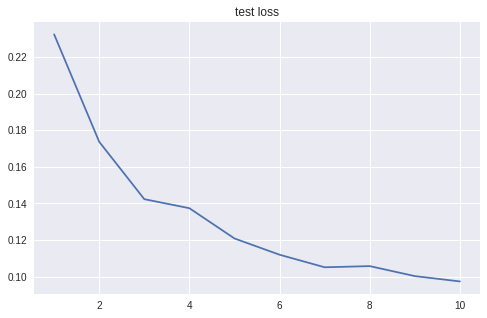

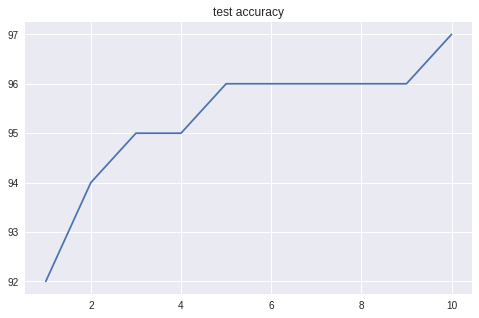

In [0]:
epochs = 10
lossv = []
accv = []
for epoch in range(1, epochs+1):
  train(epoch)
  l, a = test()
  lossv.append(l)
  accv.append(a)

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('test loss')

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('test accuracy');
print(accv)